<a href="https://colab.research.google.com/github/jwoonge/ML-algorithms/blob/master/08_Multi_Label_Classification_using_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

20141261 송제웅  
# 08 Multi Label Classification using Neural Networks  

## - function definition  
[1] read csv file

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/gdrive')

def read_file(file_name, size_row, size_col, num_class):
    f = open(file_name, "r")
    data = f.readlines()
    f.close()

    num_image = len(data)
    count = 0

    list_image = np.empty((num_image, size_row * size_col), dtype=float)
    one_hot_label = np.zeros((num_image, num_class), dtype=int)

    for line in data:
        line_data = line.split(",")
        label = line_data[0]
        im_vector = np.asfarray(line_data[1:])
        im_vector = (im_vector - np.min(im_vector)) / (np.max(im_vector)-np.min(im_vector))
        list_image[count,:] = im_vector
        one_hot_label[count][int(label)] = 1
        count += 1

    return list_image, one_hot_label

[2] Activate Function : Sigmoid  
$\sigma(z) = \frac{1}{1+exp(-z)}$  

[3] derivatived Sigmoid  
$\sigma'(z) = \sigma(z)(1-\sigma(z))$  


In [0]:
def sigmoid(input):
    return 1/(1+np.exp(-input))
def sigmoid_d(input):
    return sigmoid(input)*(1-sigmoid(input))

[4] Object function  
$J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=0}^9 (-l_k^{(i)} log(h_k^{(i)}) - (1-l_k^{(i)}) log(1-h_k^{(i)}))$


In [0]:
def loss(h, label):
    return np.sum(np.average(-label * np.log(h) - (1-label)*np.log(1-h), axis=0))

[5] Accuracy

In [0]:
def accuracy(h, label):
    forward_passed = np.argmax(h, axis=1)
    correct = forward_passed[forward_passed==np.argmax(label, axis=1)]
    return len(correct)/len(forward_passed)*100

## - Class definition  

[0] constructor  
random initial condition for weights with mean 0, and standard derivation 1

[1] calculate values by forward pass  
   return [$x\ y\_ \ y\  ... h\_ \ h$]

[2] gradient descent by backward pass  
$\theta_k^{(t+1)} := \theta_k^{(t)} - \alpha \frac{\delta J(\theta^{(t)})}{\delta \theta_k} $

gradient for $w = \frac{\delta J}{\delta w}
= (\frac{\delta J}{\delta h}*\frac{\delta h}{\delta h\_})*\frac{\delta h\_}{\delta w}$  
$=(\frac{1-l}{1-h}-\frac{l}{h})(\sigma'(h\_))*z$  

gradient for $v = \frac{\delta J}{\delta v}
= (\frac{\delta J}{\delta h}*\frac{\delta h}{\delta h\_})*(\frac{\delta h\_}{\delta z}*\frac{\delta z}{\delta z\_})*\frac{\delta z\_}{\delta v}$  
$=(\frac{1-l}{1-h}-\frac{l}{h})(\sigma'(h\_))*(w*(\sigma'(z\_)))*y$  

gradient for $u = \frac{\delta J}{\delta u}
= (\frac{\delta J}{\delta h}*\frac{\delta h}{\delta h\_})*(\frac{\delta h\_}{\delta z}*\frac{\delta z}{\delta z\_})*(\frac{\delta z\_}{\delta y}*\frac{\delta y}{\delta y\_})*\frac{\delta y\_}{\delta u}$  
$=(\frac{1-l}{1-h}-\frac{l}{h})(\sigma'(h\_))*(w*(\sigma'(z\_)))*(v*(\sigma'(y\_)))*x$

[3] optimize as repeating gradient descent

[4] predict class by forwarding using calculated weights

In [0]:
class classifier:
    def __init__(self, shape, learning_rate=1):
        self.weights = []
        for i in range(len(shape)-1):
            self.weights.append(np.random.randn(shape[i]+1, shape[i+1]))
        self.learning_rate = learning_rate
        self.num_layer = len(self.weights)
    
    def forward_pass(self, input, weights=[]):
        if weights==[]:
            weights = self.weights
        values = []
        values.append(np.insert(input, 0, 1, axis=1))
        values.append(np.dot(values[-1], weights[0]))
        values.append(np.insert(sigmoid(values[-1]),0,1,axis=1))
        for i in range(1, len(weights)-1):
            values.append(np.dot(values[-1], weights[i]))
            values.append(np.insert(sigmoid(values[-1]),0,1,axis=1))
        values.append(np.dot(values[-1], weights[-1]))
        values.append(sigmoid(values[-1]))
        return values

    def gradient_descent(self, forward_values, label):
        update_values = []
        m = len(label)
        mult = (sigmoid_d(forward_values[-2]) * ((1-label)/(1-forward_values[-1]) - label/forward_values[-1])).T
        layer = len(self.weights)-1
        update_values.append(np.dot(mult, forward_values[2*layer]).T)
        for i in range(1, len(self.weights)):
            layer = len(self.weights) - i - 1
            mult = (np.dot(mult.T, self.weights[layer+1][1:,:].T) * (sigmoid_d(forward_values[layer*2+1]))).T
            update_values.append(np.dot(mult, forward_values[2*layer]).T)
        for i in range(len(self.weights)):
            layer = len(self.weights)-i-1
            self.weights[layer] = self.weights[layer] - self.learning_rate/m * update_values[i]

    def optimize(self, data_train, label_train, data_test, label_test, epoch):
        forward_train = self.forward_pass(data_train)
        forward_test = self.forward_pass(data_test)
        h_train = forward_train[-1]
        h_test = forward_test[-1]
        loss_train = [loss(h_train, label_train)]
        loss_test = [loss(h_test, label_test)]
        accuracy_train = [accuracy(h_train, label_train)]
        accuracy_test = [accuracy(h_test, label_test)]
        self.best_train_accuracy = accuracy_train[-1]
        self.best_test_accuracy = accuracy_test[-1]
        self.best_train_loss = loss_train[-1]
        self.best_test_loss = loss_test[-1]
        self.best_weights = self.weights
        
        for i in range(epoch-1):
            self.gradient_descent(forward_train, label_train)
            forward_train = self.forward_pass(data_train)
            forward_test = self.forward_pass(data_test)
            h_train = forward_train[-1]
            h_test = forward_test[-1]
            loss_train.append(loss(h_train, label_train))
            loss_test.append(loss(h_test, label_test))
            accuracy_train.append(accuracy(h_train, label_train))
            accuracy_test.append(accuracy(h_test, label_test))
            
            if loss_test[-1] < self.best_test_loss:
                self.best_test_loss = loss_test[-1]
                self.best_train_loss = loss_train[-1]
                self.best_test_accuracy = accuracy_test[-1]
                self.best_train_accuracy = accuracy_train[-1]
                self.best_weights = self.weights

            print(i, " LOS_T:", format(loss_train[-1],'.5f'), "\tACC_T:", format(accuracy_train[-1],'.5f'), "| LOS_V:", format(loss_test[-1],'.5f'), "ACC_V:" ,format(accuracy_test[-1],'.5f'))

        return loss_train, accuracy_train, loss_test, accuracy_test
    
    def predict(self, datas):
        return self.forward_pass(datas, weights=self.best_weights)[-1]
    def predict_class(self, datas, best=True):
        if best:
            weights = self.best_weights
        else:
            weights = self.weights
        return np.argmax(self.forward_pass(datas, weights=weights)[-1], axis=1)

## - Main  
read csv file and split data into training- and testing-

In [0]:
size_row = 28
size_col = 28
num_class = 10
file_name = "gdrive/My Drive/Colab Notebooks/ML assignments/08/mnist.csv"
datas, labels = read_file(file_name, size_row, size_col, num_class)
data_train = datas[:6000,:] ; data_test = datas[6000:,:]
label_train = labels[:6000,:] ; label_test = labels[6000:,:]

create classifier object and call optimize

In [0]:
classifier = classifier([784, 196, 49, 10])
loss_train, accuracy_train, loss_test, accuracy_test = classifier.optimize(data_train, label_train, data_test, label_test, 10000)

classificate examples for result[4], with optimized classifier

In [0]:
#answers = classifier.predict_class(data_test, best=True) #use weights at minimum testing loss epoch
answers = classifier.predict_class(data_test, best=False) #use latest weights
expects = np.argmax(label_test, axis=1)
corrects = data_test[answers==expects]
corrects_label = expects[answers==expects]
incorrects = data_test[answers!=expects]
incorrects_label = expects[answers!=expects]
incorrect_answer = answers[answers!=expects]

## - Results  
[1] Plot the Loss Curve

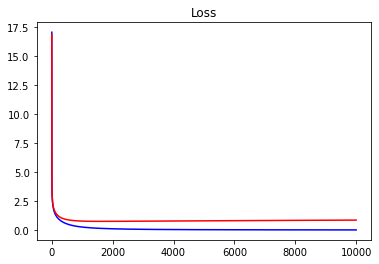

In [0]:
plt.title('Loss')
plt.plot(loss_train, c='b')
plt.plot(loss_test, c='r')
plt.show()

[2] Plot the Accuracy Curve

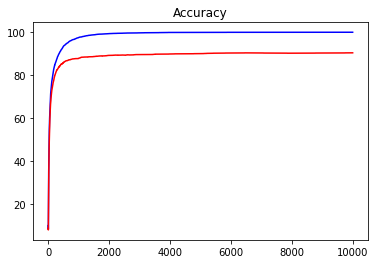

In [0]:
plt.title('Accuracy')
plt.plot(accuracy_train, c='b')
plt.plot(accuracy_test, c='r')
plt.show()

[3] Plot the Accuracy Values

In [0]:
print('final training accuracy : ',accuracy_train[-1])
print('final testing accuracy : ',accuracy_test[-1])
#print('training accuracy at minimum-test-loss epoch : ',classifier.best_train_accuracy)
#print('testing accuracy at minimum-test-loss epoch : ',classifier.best_test_accuracy)

final training accuracy :  99.98333333333333
final testing accuracy :  90.4


[4] Plot the Classification Examples  
(1) correctly classified examples

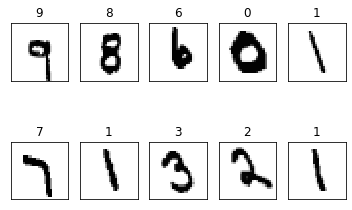

In [0]:
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(corrects_label[i]))
    plt.imshow((corrects[i]).reshape((size_row,size_col)), cmap='Greys', interpolation='None')
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()

(2) misclassified examples

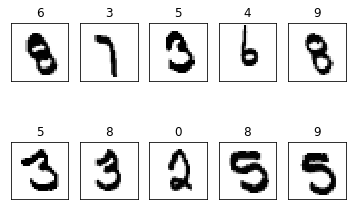

In [0]:
plt.figure('misclassified')
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(incorrect_answer[i]))
    plt.imshow((incorrects[i]).reshape((size_row,size_col)), cmap='Greys', interpolation='None')
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()